In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils as u

EQ_CENTS = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
JI_CENTS = np.array([0, 90, 112, 182, 204, 294, 316, 386, 408, 498, 520, 590, 612, 702, 792, 814, 884, 906, 996, 1018, 1088, 1110, 1200])

# %matplotlib widget

In [3]:
# Load audiofile at 16kHz
audiofile = "thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin-aalapana.mp3"
sr = 16000
y, sr = u.load_normalize(audiofile, sr = sr)

# Apply a high pass filter to the audio signal (160 Hz)
y_filt = u.high_pass(y, sr, 160, order = 10)
y_filt = y_filt.astype(np.float32)  

In [4]:
# Identify the tonic
tonic = u.identify_tonic(y, sr, binResolution = 1)
print(f"Identified tonic: {tonic} Hz")

Identified tonic: 181.02346801757812 Hz


In [44]:
# Calculate raw pitch with melodia
hopsize_ms = 7.5
binResolution = 1
hopSize = u.ms_to_samples(hopsize_ms, sr)
minFrequency = tonic - 1
f0, conf = u.melodia(y, sr, hopSize = hopSize, minFrequency = minFrequency, binResolution = binResolution)

In [46]:
# Save the pitch contour
pitchfile = "thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin-aalapana.pitch"
times = np.linspace(0, length, len(f0))
np.savetxt(pitchfile, np.array([times, f0, conf]).T)

In [6]:
# Load the pitch contour
pitchfile = "thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin-aalapana.pitch"
times, f0, conf = np.loadtxt(pitchfile).T

In [7]:
# Length of audio in seconds
length = len(y)/sr

# Pitch contour frame rate
frameRate = int(len(f0)/length)  
print("Pitch contour frame rate: ", frameRate)

# Get voiced segments
voiced_segments = u.voiced_segments(f0)
print(len(voiced_segments))

Pitch contour frame rate:  133
248


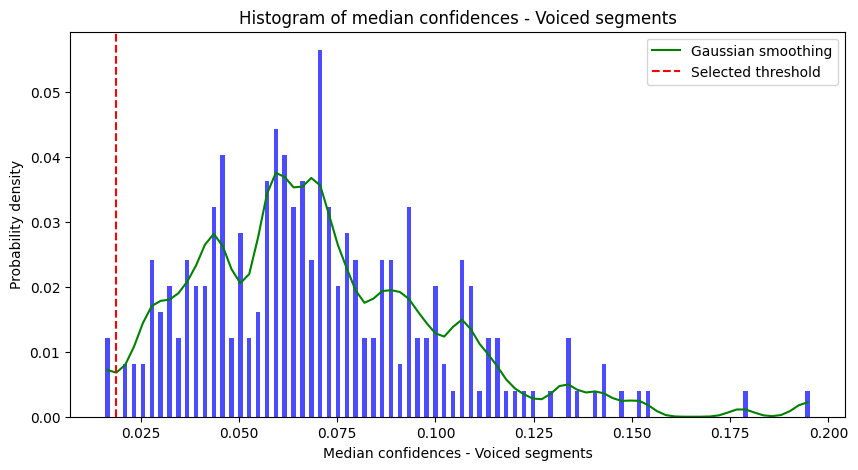

In [8]:
# Removing segments with low confidence estimation
median_conf = u.median_confidences(conf, voiced_segments)
plt.figure(figsize=(10, 5))
hist, bin_edges = np.histogram(median_conf, bins = 80, density = True)
hist = hist/np.sum(hist)
peaks = u.find_minimas(hist, height = 0.01)
gaussian_fit = u.gaussian_filter(hist, 10, sigma = 1.5)
plt.bar(bin_edges[:-1], hist, width = 0.5*(bin_edges[1] - bin_edges[0]), color = 'b', alpha = 0.7)
plt.plot(bin_edges[:-1], gaussian_fit, color = 'g', label = "Gaussian smoothing")
plt.axvline(x = bin_edges[peaks[0]], color = 'r', linestyle = '--', label = "Selected threshold")
plt.xlabel("Median confidences - Voiced segments")
plt.ylabel("Probability density")
plt.title("Histogram of median confidences - Voiced segments")
plt.legend()
plt.show()

In [9]:
f0_filt = f0.copy()
threshold = bin_edges[peaks[0]]
for i in range(len(voiced_segments)):
    if median_conf[i] < threshold:
        start = voiced_segments[i][0]
        end = voiced_segments[i][1] + 1
        f0_filt[start:end] = 0

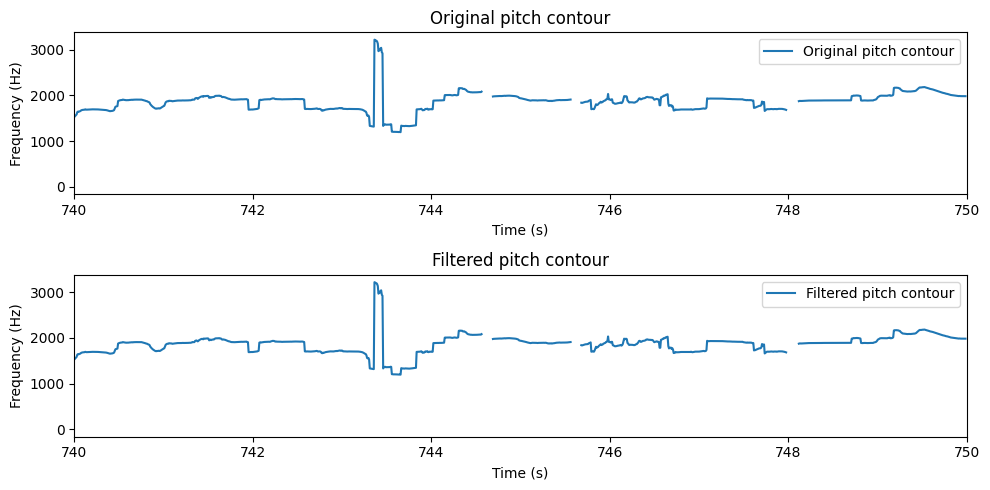

In [15]:
t1 = 740
t2 = 750
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(times, u.hz_to_cents(f0, tonic), label = "Original pitch contour")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Original pitch contour")
plt.xlim(t1, t2)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(times, u.hz_to_cents(f0_filt, tonic), label = "Filtered pitch contour")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Filtered pitch contour")
plt.legend()
plt.xlim(t1, t2)
plt.tight_layout()
plt.show()

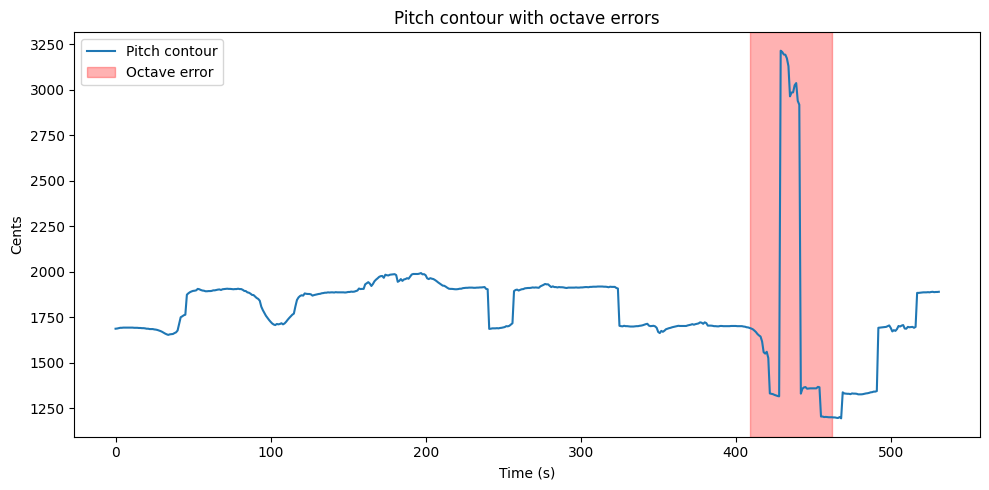

In [96]:
# Correct octave errors
window_ms = 160
window_samples = u.ms_to_samples(window_ms, 133)
t1 = 742
t2 = 746
t1_sample = int(t1*133)
t2_sample = int(t2*133)
seg = f0_filt[t1_sample:t2_sample]
seg = u.hz_to_cents(seg, tonic)

# Detect octave errors
octave_errors = []
for i in range(len(seg) - window_samples):
    window = seg[i:i + window_samples]
    min = np.min(window)
    max = np.max(window)
    if max - min > 700:
        octave_errors.append((i, i + window_samples))

octave_errors = u.merge_intervals(octave_errors)
plt.figure(figsize=(10, 5))
plt.plot(seg, label = "Pitch contour")
plt.axvspan(octave_errors[0][0], octave_errors[0][1], color = 'r', alpha = 0.3, label = "Octave error")
plt.xlabel("Time (s)")
plt.ylabel("Cents")
plt.title("Pitch contour with octave errors")
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
y_pitch_filt = u.sonify_pitch_contour(times, f0_filt)
u.save_audio("thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin-alaapana.wav", y_pitch_filt, sr)

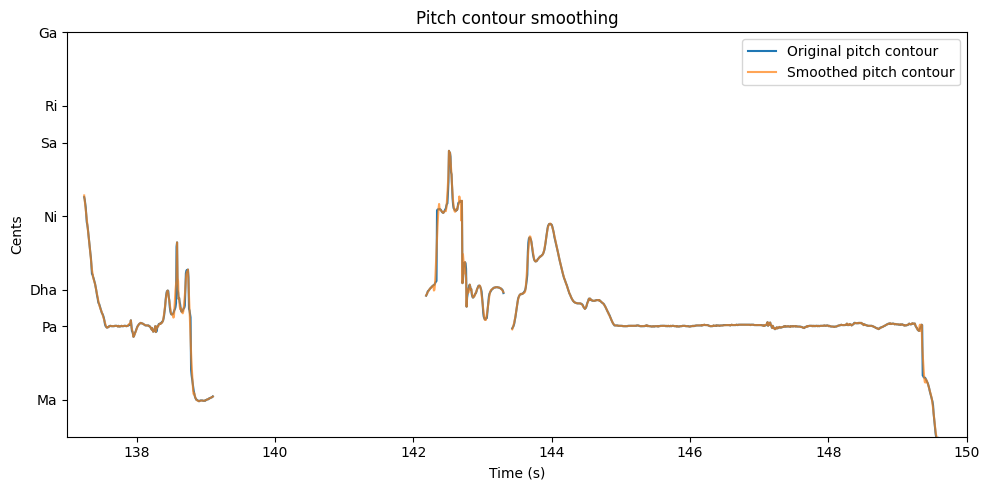

In [123]:
# Pitch contour smoothing and interpolation
window_ms = 100
window_samples = u.ms_to_samples(window_ms, 133)
f0_smoothed = u.savitsky_golay_filter(f0_filt, window_samples, 2, peak = True)
notes_dict = {
"Sa": 0,
"Ri": 100,
"Ga": 300,
"Ma": 500,
"Pa": 700,
"Dha": 800,
"Ni": 1000,
"Sa": 1200,
"Ri": 1300,
"Ga": 1500,
}
plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_filt, tonic), label = "Original pitch contour")
plt.plot(times, u.hz_to_cents(f0_smoothed, tonic), label = "Smoothed pitch contour", alpha = 0.7)
plt.xlabel("Time (s)")
plt.ylabel("Cents")
plt.xlim(137, 150)
plt.ylim(400, 1500)
plt.yticks(list(notes_dict.values()), list(notes_dict.keys()))
plt.title("Pitch contour smoothing")
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
# Extract vocal pitch and tonic
vocal_pitchfile = "thodi/Koluvamaregatha/Koluvamaregatha.multitrack-vocal-alaapana-pitch.txt"
vocal_file = "thodi/Koluvamaregatha/Koluvamaregatha.multitrack-vocal-alaapana.mp3"
vocal_tonicfile = "thodi/Koluvamaregatha/Koluvamaregatha.ctonic.txt" 
times_vocal, f0_vocal = np.loadtxt(vocal_pitchfile).T
tonic_vocal = np.loadtxt(vocal_tonicfile)
y_vocal, sr = u.load_normalize(vocal_file, sr = None)
length = len(y_vocal)/sr
framerate_vocal = int(len(f0_vocal)/length)

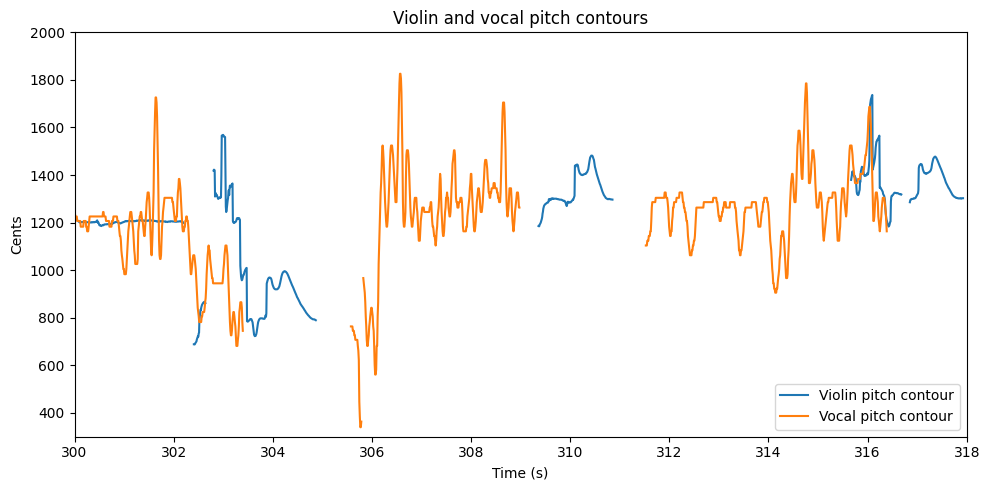

In [114]:
# Plot vocal and violin pitch contours
plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_filt, tonic), label = "Violin pitch contour")
plt.plot(times_vocal, u.hz_to_cents(f0_vocal, tonic_vocal), label = "Vocal pitch contour")
plt.xlabel("Time (s)")
plt.ylabel("Cents")
plt.title("Violin and vocal pitch contours")
plt.xlim(300, 318)
plt.ylim(300, 2000)
plt.legend(loc = "lower right")  
plt.tight_layout()
plt.show()


In [10]:
# Cents calculation
cents_vi = u.hz_to_cents(f0_filt, tonic)
cents_vi = u.wrap_to_octave(cents_vi)

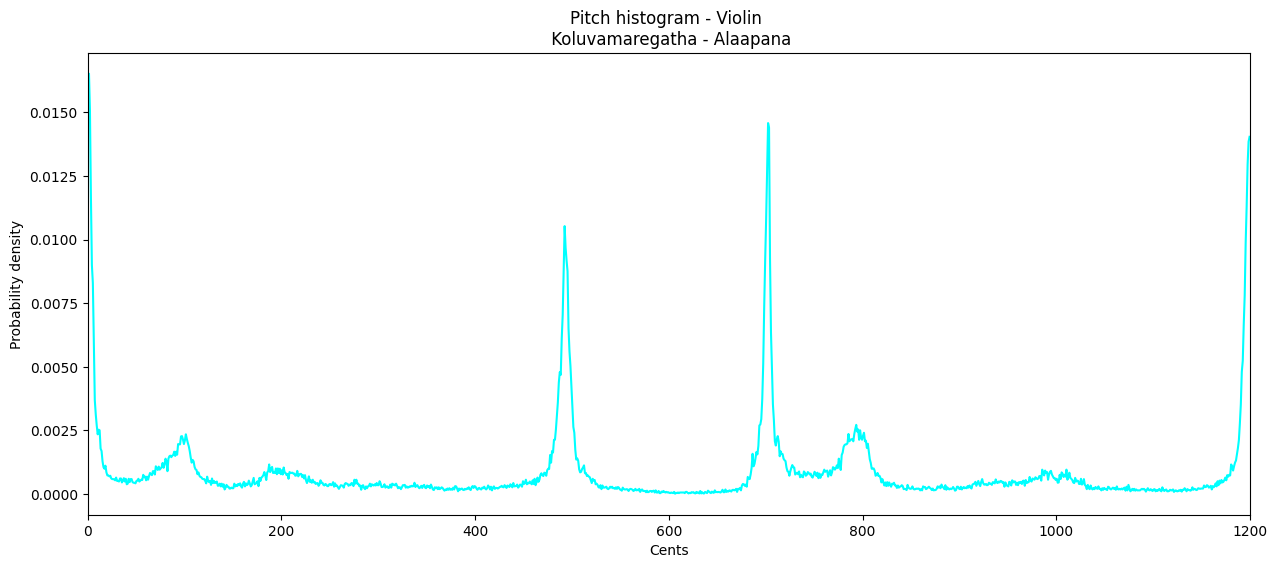

In [11]:
# Plot histogram
bins = np.linspace(0, 1200, 1201)
hist, bin_edges = np.histogram(cents_vi, bins = bins)
hist = hist/np.sum(hist)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2    

plt.figure(figsize=(15, 6))
plt.plot(bin_centers, hist, color = "cyan")
# for pos in JI_CENTS:
#     plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
# for pos in EQ_CENTS:
#     plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Probability density")
plt.xlim(0, 1200)
plt.title("Pitch histogram - Violin \n Koluvamaregatha - Alaapana")
plt.show()       


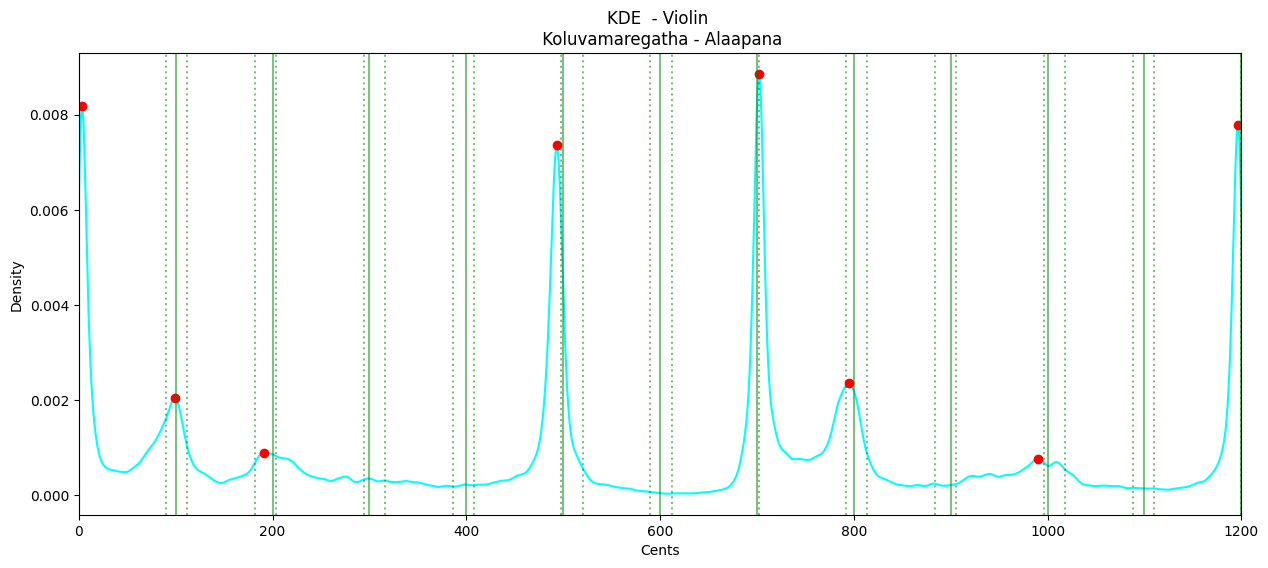

In [25]:
# KDE calculation
kde = u.gaussian_kde(cents_vi[~np.isnan(cents_vi)], bw_method = 0.01)
bins = np.linspace(0, 1200, 1200)
kde_vals = kde(bins)

# Find peaks in KDE
peaks,_ = u.find_peaks(kde_vals, distance = 50, height = 0.0005)

# Plot KDE and peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE  - Violin \n Koluvamaregatha - Alaapana")
plt.show()


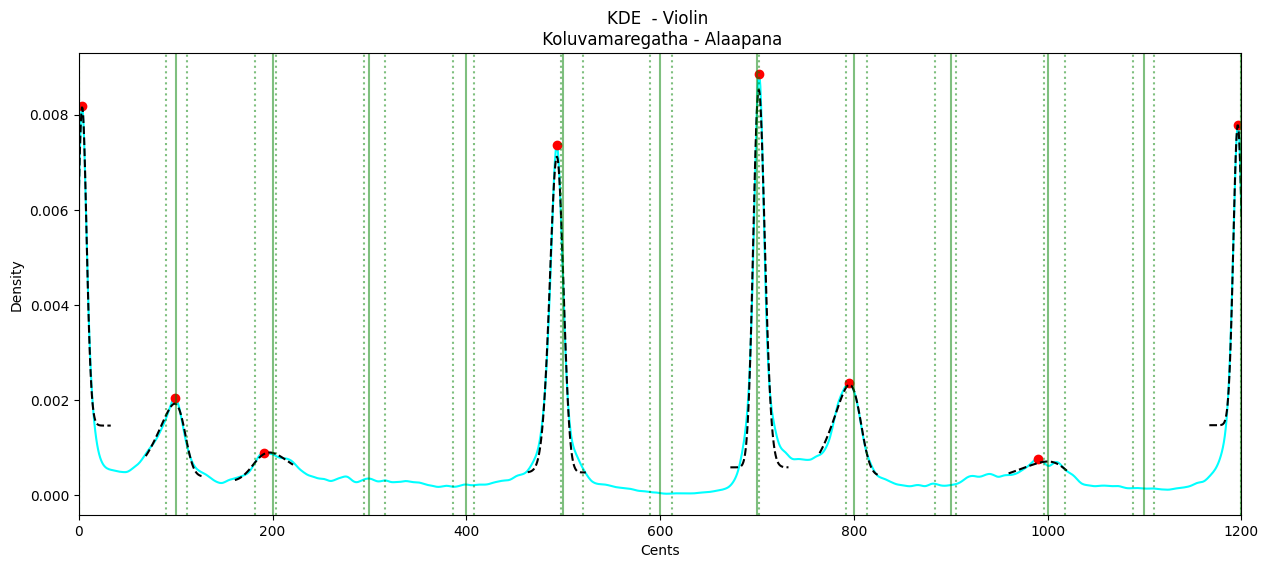

In [26]:
# Find peak parameters
peak_dict = u.fit_histogram(peaks, kde_vals, bins)

# Plot KDE and fitted peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for peak, params in peak_dict.items():
    start = peak - 30
    end = peak + 30
    x_vals = np.linspace(start, end, 100)
    y_vals = u.gaussian(x_vals, *params)
    plt.plot(x_vals, y_vals, linestyle = '--', color = 'k')

for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE  - Violin \n Koluvamaregatha - Alaapana")
plt.show()


In [27]:
# For each peak, find the closest JI and EQ pitch
ji_pitch = []
eq_pitch = []
ji_diff = []
eq_diff = []
for peak in peaks:
    peak_pos = int(bins[peak])
    ji = JI_CENTS[np.argmin(np.abs(JI_CENTS - peak_pos))]
    eq = EQ_CENTS[np.argmin(np.abs(EQ_CENTS - peak_pos))]
    ji_pitch.append(ji)
    eq_pitch.append(eq)
    ji_diff.append(np.abs(peak_pos - ji))
    eq_diff.append(np.abs(peak_pos - eq))

import pandas as pd
df = pd.DataFrame(list(zip(bins[peaks].astype(int), ji_pitch, ji_diff, eq_pitch, eq_diff)), columns = ["Peak", "JI", "JI_diff", "EQ", "EQ_diff"])
display(df)

,Peak,JI,JI_diff,EQ,EQ_diff
0,3,0,3,0,3
1,99,90,9,100,1
2,191,182,9,200,9
3,493,498,5,500,7
4,702,702,0,700,2
5,794,792,2,800,6
6,989,996,7,1000,11
7,1196,1200,4,1200,4


In [23]:
ji_std = np.std(ji_diff)
eq_std = np.std(eq_diff)
print(f"JI std: {ji_std}")
print(f"EQ std: {eq_std}")

JI std: 2.947456530637899
EQ std: 3.122498999199199


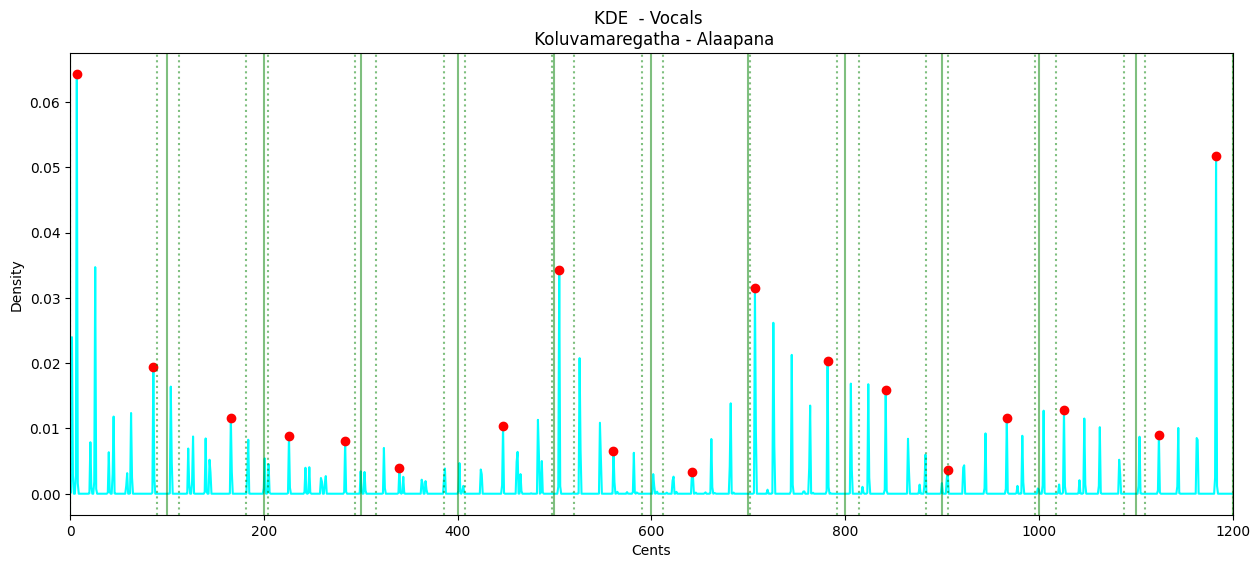

In [120]:
# Convert to cents and plot
cents_vo = u.hz_to_cents(f0_vocal, tonic_vocal)
# Wrap cents to one octave
cents_vo = u.wrap_to_octave(cents_vo)

# KDE calculation
kde = u.gaussian_kde(cents_vo[~np.isnan(cents_vo)], bw_method = 0.001)
bins = np.linspace(0, 1200, 1201)
kde_vals = kde(bins)

# Find peaks in KDE
peaks,_ = u.find_peaks(kde_vals, distance = 50, height = 0.0005)

# Plot KDE and peaks
plt.figure(figsize=(15, 6))
plt.plot(bins, kde_vals, color = "cyan")
plt.plot(bins[peaks], kde_vals[peaks], 'ro')
for pos in JI_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = ':', alpha = 0.5)
for pos in EQ_CENTS:
    plt.axvline(x = pos, color = 'g', linestyle = '-', alpha = 0.5)
plt.xlabel("Cents")
plt.ylabel("Density")
plt.xlim(0, 1200)
plt.title("KDE  - Vocals \n Koluvamaregatha - Alaapana")
plt.show()


In [39]:
import pandas as pd
notes = ['S', 'R1', 'G2', 'M1', 'P', 'D1', 'N2']
print(peaks_vi)
print(peaks_vo)

[   1   98  190  492  700  792  993 1168]
[  10  100  180  500  700  750  800 1000 1190]


In [40]:
# For each element in peaks_vi, find the closest element in JI_CENTS and EQ_CENTS
# For each element in peaks_vo, find the closest element in JI_CENTS and EQ_CENTS

# Violin
violin_peaks = []
for peak in peaks_vi:
    closest_JI = np.argmin(np.abs(JI_CENTS - bin_centers[peak]))
    closest_EQ = np.argmin(np.abs(EQ_CENTS - bin_centers[peak]))
    violin_peaks.append((bin_centers[peak], JI_CENTS[closest_JI], EQ_CENTS[closest_EQ]))

# Vocals
vocals_peaks = []
for peak in peaks_vo:
    closest_JI = np.argmin(np.abs(JI_CENTS - bin_centers[peak]))
    closest_EQ = np.argmin(np.abs(EQ_CENTS - bin_centers[peak]))
    vocals_peaks.append((bin_centers[peak], JI_CENTS[closest_JI], EQ_CENTS[closest_EQ]))

print(violin_peaks)
print(vocals_peaks)

[(1.5, 0, 0), (98.5, 90, 100), (190.5, 182, 200), (492.5, 498, 500), (700.5, 702, 700), (792.5, 792, 800), (993.5, 996, 1000), (1168.5, 1200, 1200)]
[(10.5, 0, 0), (100.5, 90, 100), (180.5, 182, 200), (500.5, 498, 500), (700.5, 702, 700), (750.5, 792, 800), (800.5, 792, 800), (1000.5, 996, 1000), (1190.5, 1200, 1200)]
